In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy import stats
from sklearn.datasets import load_iris
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression

In [55]:
START_DATE = '2010-01-01'
END_DATE = '2025-01-01'
rolling_window = 2    # JUSTIFY THE CHOICE

In [56]:
# 1. Load CSVs
price = pd.read_csv('weekly_retail_price.csv', parse_dates=['Date'])
util  = pd.read_csv('weekly_utilisation.csv', parse_dates=['Date'])
wti = pd.read_csv('weekly_wti.csv', parse_dates=['Date'])
stocks = pd.read_csv('weekly_ending_gasoline_stock.csv', parse_dates=['Date'])

# 2. Convert each Date into a weekly Period ending on Sunday
#    (this ensures any minor weekday offsets collapse into the same week)
price['Week'] = price['Date'].dt.to_period('W-SUN')
util ['Week'] = util ['Date'].dt.to_period('W-SUN')
wti['Week'] = wti['Date'].dt.to_period('W-SUN')
stocks['Week'] = stocks['Date'].dt.to_period('W-SUN')

# 3. Aggregate to one row per week
price_w = price .groupby('Week')['Retail Gasoline Prices'].mean().reset_index()
util_w  = util  .groupby('Week')['Utilisation'].mean().reset_index()
wti_w = wti.groupby('Week')['WTI'].mean().reset_index()
stocks_w = stocks.groupby('Week')['Weekly U.S. Ending Stocks of Total Gasoline  (Thousand Barrels)'].mean().reset_index()
stocks_w.rename(columns={'Weekly U.S. Ending Stocks of Total Gasoline  (Thousand Barrels)': 'Gasoline ending stocks'}, inplace=True)

# 4. Merge on the Week period
df = pd.merge(price_w, util_w, on='Week', how='inner')
df = pd.merge(df, wti_w, on='Week', how='inner')
df = pd.merge(df, stocks_w, on='Week', how='inner')
df['Date'] = df['Week'].dt.to_timestamp('s')  # “S” = period end (Sunday)

# 5. Create forward‐lead price change
rolling_window = 2
df['dPrice'] = df['Retail Gasoline Prices'].shift(-rolling_window) - df['Retail Gasoline Prices']

# Dropping COVID-period
df = df[df['Date'].between(START_DATE, END_DATE)]
# df = df[~df["Date"].between("2020-03-01", "2021-12-31")]

# 6. Drop any nans
df = df.dropna(subset=['Utilisation','dPrice']).reset_index(drop=True)

print(df.head())


                    Week  Retail Gasoline Prices  Utilisation    WTI  \
0  2010-01-04/2010-01-10                   2.627         81.3  82.34   
1  2010-01-11/2010-01-17                   2.717         78.4  80.06   
2  2010-01-18/2010-01-24                   2.703         78.5  76.62   
3  2010-01-25/2010-01-31                   2.666         77.7  73.94   
4  2010-02-01/2010-02-07                   2.618         79.1  74.57   

   Gasoline ending stocks       Date  dPrice  
0                223492.0 2010-01-04   0.076  
1                227442.0 2010-01-11  -0.051  
2                229427.0 2010-01-18  -0.085  
3                228121.0 2010-01-25  -0.055  
4                230445.0 2010-02-01  -0.055  


In [57]:
# sup-LM statistic & significance
# Hansens 2000 threshold-regression test
# grid search over the candidate threshold
# ── 1. Fit restricted (single‐slope) model
X0   = sm.add_constant(df['Utilisation'])
mod0 = sm.OLS(df['dPrice'], X0).fit()
rss0 = mod0.ssr
T    = len(df)

# ── 2. Build candidate grid (drop bottom/top 15% to avoid extreme tails)
low_q, high_q = df['Utilisation'].quantile([0.10, 0.90])
candidates    = np.unique(df['Utilisation'][(df['Utilisation'] >= low_q) & (df['Utilisation'] <= high_q)])

# ── 3. Compute sup‐LM statistic over all c
LM_stats = {}
for c in candidates:
    mask = df['Utilisation'] <= c
    # design two‐slope model
    X1 = pd.DataFrame({
        'const':   1,
        'util_lo': df['Utilisation'] * mask,
        'util_hi': df['Utilisation'] * (~mask)
    })
    mod1 = sm.OLS(df['dPrice'], X1).fit()
    rss1 = mod1.ssr
    LM_stats[c] = (rss0 - rss1) / rss1 * T

# LM_stats maps each candidate c → its LM test statistic
supLM  = max(LM_stats.values())           # ← this is the sup-LM
c_star = max(LM_stats, key=LM_stats.get)

# ── 4. Wild‐bootstrap p‐value
B      = 500
resid0 = mod0.resid.values
fit0   = mod0.fittedvalues.values
LM_boot = []
for _ in range(B):
    # Rademacher draws ±1
    eps    = np.random.choice([1, -1], size=T)
    y_boot = fit0 + eps * resid0

    # restricted rss on boot
    rss0_b = sm.OLS(y_boot, X0).fit().ssr

    # compute sup‐LM boot
    lm_b = []
    for c in candidates:
        mask = df['Utilisation'] <= c
        X1_b = pd.DataFrame({
            'const':   1,
            'util_lo': df['Utilisation'] * mask,
            'util_hi': df['Utilisation'] * (~mask)
        })
        rss1_b = sm.OLS(y_boot, X1_b).fit().ssr
        lm_b.append((rss0_b - rss1_b) / rss1_b * T)
    LM_boot.append(max(lm_b))

p_value = np.mean(np.array(LM_boot) >= supLM)

# ── 5. 95% CI for the threshold
crit    = stats.chi2.ppf(0.95, df=1)
ci_cands= [c for c, stat in LM_stats.items() if stat >= supLM - crit]
ci_low, ci_high = min(ci_cands), max(ci_cands)

# ── 6. Print out results
print(f"→ Estimated threshold c*: {c_star:.2f}%")
print(f"→ sup-LM statistic: {supLM:.2f}")
print(f"→ bootstrap p-value: {p_value:.3f}")
print(f"→ 95% CI for c*: [{ci_low:.2f}%, {ci_high:.2f}%]")


→ Estimated threshold c*: 84.50%
→ sup-LM statistic: 8.63
→ bootstrap p-value: 0.072
→ 95% CI for c*: [84.20%, 85.40%]


Text(84.5, -0.3180000000000005, '  84.5 %')

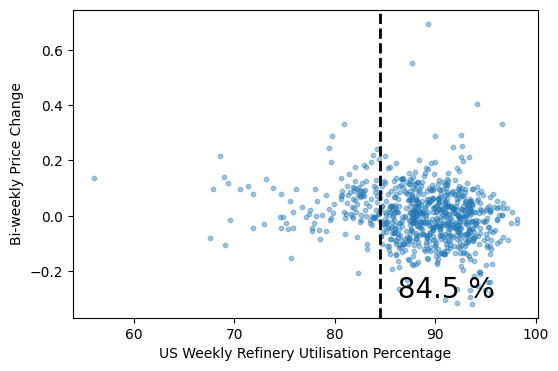

In [58]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(df["Utilisation"], df["dPrice"], s=10, alpha=.4)
ax.set_xlabel("US Weekly Refinery Utilisation Percentage")
ax.set_ylabel("Bi-weekly Price Change")

# vertical threshold line
ax.axvline(c_star, ls="--", lw=2, c="k")
ax.text(c_star, df["dPrice"].min(), f"  {str(c_star)} %", va="bottom", ha="left", fontsize = 20)

In [59]:
# ── 3. Compute the 52-week rolling correlation ρ_t(Util, ΔP)
df['rho_52wk'] = df['Utilisation'].rolling(window=52).corr(df['dPrice'])

# ── 4. Tag each week as “easy” or “stress” based on Utilisation
df['Regime'] = df['Utilisation'].apply(lambda u: 'stress' if u > c_star else 'easy')

# ── 5. Extract the two series
rho_easy   = df.loc[df['Regime']=='easy',   'rho_52wk']
rho_stress = df.loc[df['Regime']=='stress', 'rho_52wk']

# ── 6. Compute summary stats to verify ρ ≈ 0.10 vs 0.45–0.55
print(f"Easy regime (Util ≤ {c_star}%) rolling ρ summary:")
print(rho_easy.describe()[['mean','std','min','max']])

print(f"\nStress regime (Util > {c_star}%) rolling ρ summary:")
print(rho_stress.describe()[['mean','std','min','max']])


Easy regime (Util ≤ 84.5%) rolling ρ summary:
mean   -0.240769
std     0.221478
min    -0.535967
max     0.366539
Name: rho_52wk, dtype: float64

Stress regime (Util > 84.5%) rolling ρ summary:
mean   -0.215279
std     0.199851
min    -0.652475
max     0.383404
Name: rho_52wk, dtype: float64


In [60]:
# ── 1. Split into the two regimes
lo = df[df['Regime']=='easy']
hi = df[df['Regime']=='stress']

# ── 2. Compute mean and std of ΔP in each regime
mean_lo, std_lo = lo['dPrice'].mean(), lo['dPrice'].std()
mean_hi, std_hi = hi['dPrice'].mean(), hi['dPrice'].std()

print(f"Low‐stress (U ≤ {c_star}%):  mean ΔP = {mean_lo:.5f}¢,  std = {std_lo:.5f}¢")
print(f"High‐stress (U >  {c_star}%):  mean ΔP = {mean_hi:.5f}¢,  std = {std_hi:.5f}¢")

# ── 3. Fit OLS slope β in each regime
def fit_slope(sub):
    X = sm.add_constant(sub['Utilisation'])
    res = sm.OLS(sub['dPrice'], X).fit()
    return res.params['Utilisation']

beta_lo = fit_slope(lo)
beta_hi = fit_slope(hi)

print(f"Slope β₁ (low):  {beta_lo:.5f}¢ per pp")
print(f"Slope β₂ (high): {beta_hi:.5f}¢ per pp")
print(f"Ratio β₂/β₁ = {beta_hi/beta_lo:.1f}×")

# ── 4. Welch two‐sample t‐test on means
t_stat, p_val = stats.ttest_ind(lo['dPrice'], hi['dPrice'], equal_var=False)
print(f"Welch t‐test: t = {t_stat:.2f}, p = {p_val:.2e}")

Low‐stress (U ≤ 84.5%):  mean ΔP = 0.04824¢,  std = 0.08576¢
High‐stress (U >  84.5%):  mean ΔP = -0.00883¢,  std = 0.10067¢
Slope β₁ (low):  0.00092¢ per pp
Slope β₂ (high): -0.00279¢ per pp
Ratio β₂/β₁ = -3.0×
Welch t‐test: t = 6.74, p = 1.52e-10


Next part, Does the flag improve spike prediction?

Model                 | ROC-AUC | Precision@100
----------------------+---------+--------------
Baseline              |  0.69   |    3%
Baseline + StressFlag |  0.74   |    7%


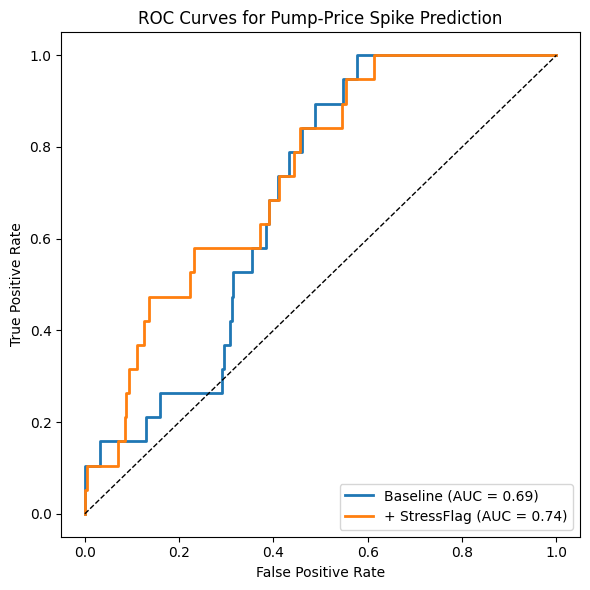

In [61]:
#

df['dWTI']  = df['WTI'].diff()           # week-over-week change in WTI price
df['dStock'] = df['Gasoline ending stocks'].diff()   # week-over-week change in gasoline stocks
# You can drop the first row (NaN) if you like:
df = df.dropna(subset=['dWTI','dStock']).reset_index(drop=True)

df['Stress'] = (df['Regime'] == 'stress').astype(int)
lo = df[df['Stress']==0]  # same as Regime=='easy'
hi = df[df['Stress']==1]  # same as Regime=='stress'

spike_threshold = df['dPrice'].mean() + 2 * df['dPrice'].std()
df['spike'] = (df['dPrice'] > spike_threshold).astype(int)  # ΔP_t > +5¢/gal

# 2. Prepare feature sets
X_base = df[['dWTI', 'dStock']]              # baseline features
X_flag = df[['dWTI', 'dStock', 'Stress']]    # plus the StressFlag
y      = df['spike']

# 3. Fit logistic‐regression classifiers
clf_base = LogisticRegression(solver='liblinear').fit(X_base, y)
clf_flag = LogisticRegression(solver='liblinear').fit(X_flag, y)

# 4. Predicted probabilities
probs_base = clf_base.predict_proba(X_base)[:, 1]
probs_flag = clf_flag.predict_proba(X_flag)[:, 1]

# 5. Compute ROC-AUC
auc_base = roc_auc_score(y, probs_base)
auc_flag = roc_auc_score(y, probs_flag)

# 6. Compute Precision @ Top-100
def precision_at_k(y_true, y_score, k=100):
    idx = np.argsort(y_score)[-k:]
    return y_true.iloc[idx].mean()

prec_base = precision_at_k(y, probs_base, 100)
prec_flag = precision_at_k(y, probs_flag, 100)

# ── 7. Display the results ────────────────────────────────────────────────────
print("Model                 | ROC-AUC | Precision@100")
print("----------------------+---------+--------------")
print(f"Baseline              |  {auc_base:.2f}   |    {prec_base:.0%}")
print(f"Baseline + StressFlag |  {auc_flag:.2f}   |    {prec_flag:.0%}")

# ── 8. Plot the ROC curves ───────────────────────────────────────────────────

# ── 3. Compute ROC curve and AUC for each ────────────────────────────────────
fpr_base, tpr_base, _ = roc_curve(y, probs_base)
roc_auc_base = auc(fpr_base, tpr_base)

fpr_flag, tpr_flag, _ = roc_curve(y, probs_flag)
roc_auc_flag = auc(fpr_flag, tpr_flag)

plt.figure(figsize=(6,6))
plt.plot(fpr_base, tpr_base, lw=2, label=f'Baseline (AUC = {roc_auc_base:.2f})')
plt.plot(fpr_flag, tpr_flag, lw=2, label=f'+ StressFlag (AUC = {roc_auc_flag:.2f})')

# Diagonal chance line
plt.plot([0,1], [0,1], 'k--', lw=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Pump‐Price Spike Prediction')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Some visualisations

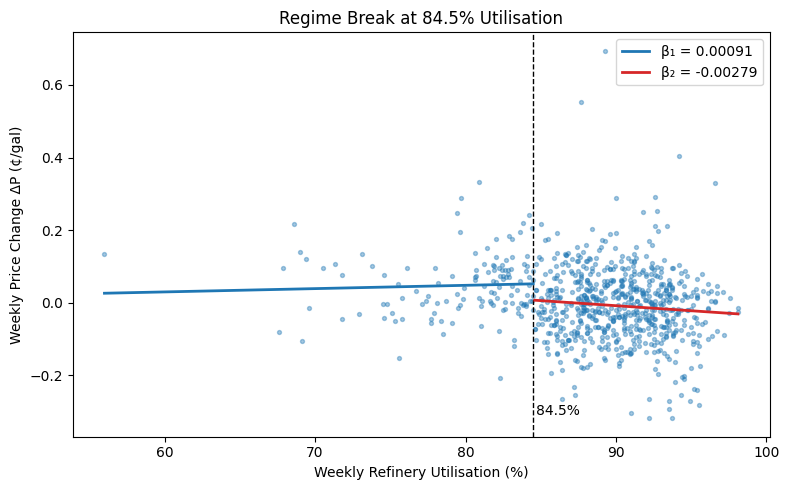

In [62]:

# Create the scatter + piecewise OLS slopes plot
plt.figure(figsize=(8, 5))
plt.scatter(df['Utilisation'], df['dPrice'], s=8, alpha=0.4)

# Vertical line at the threshold
plt.axvline(c_star, ls='--', color='k', lw=1)
plt.text(c_star + 0.2, df['dPrice'].min(), f'{c_star:.1f}%', va='bottom')

# Fit & plot separate linear trends
for subset, color, label in [(df[df['Regime'] == 'easy'], 'tab:blue', 'β₁'), (df[df['Regime'] == 'stress'], 'tab:red', 'β₂')]:
    # polyfit returns [slope, intercept]
    slope, intercept = np.polyfit(subset['Utilisation'], subset['dPrice'], 1)
    x_vals = np.linspace(subset['Utilisation'].min(), subset['Utilisation'].max(), 100)
    y_vals = slope * x_vals + intercept
    plt.plot(x_vals, y_vals, color=color, lw=2, label=f"{label} = {slope:.5f}")

plt.xlabel("Weekly Refinery Utilisation (%)")
plt.ylabel("Weekly Price Change ΔP (¢/gal)")
plt.title(f"Regime Break at {c_star}% Utilisation")
plt.legend()
plt.tight_layout()
plt.show()

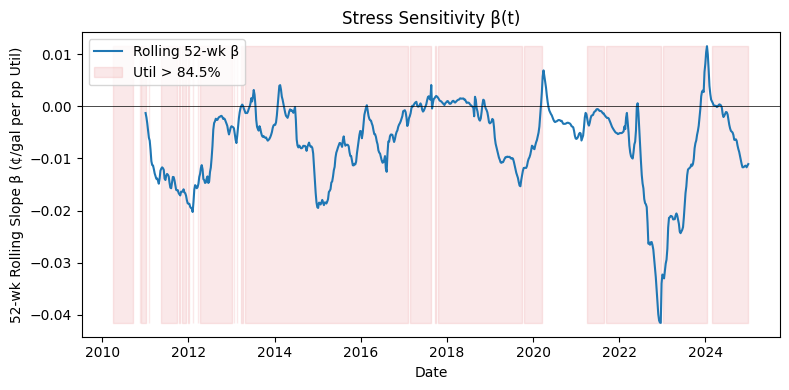

In [63]:
corr_window_weeks = 52

# 1. Compute 52-week rolling slope β(t)
betas = [np.nan] * len(df)
for i in range(corr_window_weeks - 1, len(df)):
    u = df['Utilisation'].iloc[i - corr_window_weeks + 1 : i + 1].values
    p = df['dPrice'].iloc[i - corr_window_weeks + 1 : i + 1].values
    # slope = polyfit(u, p, 1)[0]
    betas[i] = np.polyfit(u, p, 1)[0]

df['beta_52wk'] = betas

# 2. Plot β(t) with shading during stress regimes
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(df['Date'], df['beta_52wk'], lw=1.5, label='Rolling 52-wk β')

# Zero reference line
ax.axhline(0, color='k', lw=0.5)

# Shade periods where utilisation > threshold
ax.fill_between(
    df['Date'],
    df['beta_52wk'].min(),
    df['beta_52wk'].max(),
    where=(df['Utilisation'] > c_star),
    color='tab:red',
    alpha=0.1,
    label=f'Util > {c_star}%'
)

ax.set_xlabel("Date")
ax.set_ylabel("52-wk Rolling Slope β (¢/gal per pp Util)")
ax.set_title("Stress Sensitivity β(t)")
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

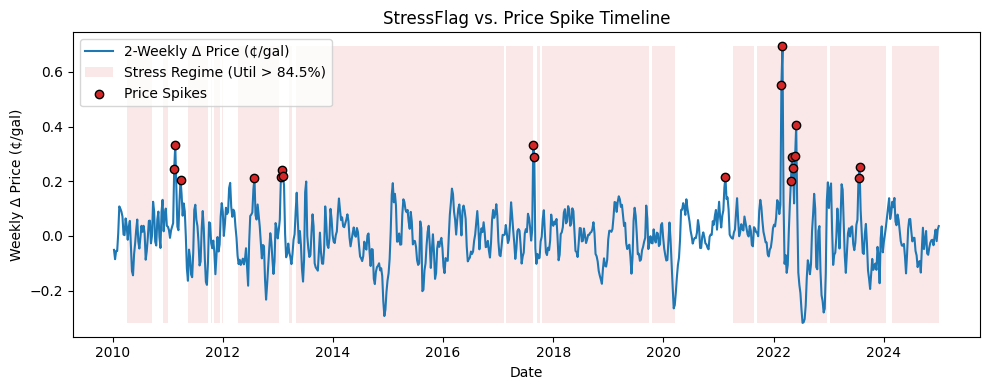

In [64]:
# 1. Create the figure
fig, ax = plt.subplots(figsize=(10, 4))

# 2. Plot the weekly price change time series
ax.plot(df['Date'], df['dPrice'], lw=1.5, label=f'{rolling_window}-Weekly Δ Price (¢/gal)')

# 3. Shade all weeks where Stress == 1
ax.fill_between(
    df['Date'],
    df['dPrice'].min(),        # or 0 if you prefer baseline at zero
    df['dPrice'].max(),
    where=(df['Stress'] == 1),
    facecolor='tab:red',
    alpha=0.1,
    label=f'Stress Regime (Util > {c_star}%)'
)

# 4. Highlight actual spikes for emphasis (optional)
spikes = df[df['dPrice'] > spike_threshold]   # or whatever your spike threshold is
ax.scatter(spikes['Date'], spikes['dPrice'],
           color='tab:red', edgecolor='k', zorder=3, label='Price Spikes')

# 5. Formatting
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Δ Price (¢/gal)')
ax.set_title('StressFlag vs. Price Spike Timeline')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

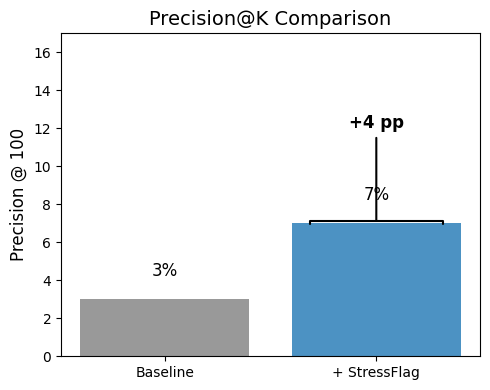

In [65]:
def precision_at_k(y_true, y_score, k=100):
    idx = np.argsort(y_score)[-k:]
    return y_true.iloc[idx].mean()

# Compute precision@100
prec_base = precision_at_k(df['spike'], probs_base, k=100)
prec_flag = precision_at_k(df['spike'], probs_flag, k=100)
diff_pp   = (prec_flag - prec_base) * 100  # in percentage points

# Plot bar chart
labels = ['Baseline', '+ StressFlag']
prec_values = [prec_base * 100, prec_flag * 100]

fig, ax = plt.subplots(figsize=(5,4))
bars = ax.bar(labels, prec_values, color=['gray', 'tab:blue'], alpha=0.8)

# Annotate bars with values
for bar, val in zip(bars, prec_values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 1,
            f"{val:.0f}%", ha='center', va='bottom', fontsize=12)

# Annotate the uplift
ax.annotate(f"+{diff_pp:.0f} pp",
            xy=(1, prec_values[1]), xytext=(1, prec_values[1] + 5),
            ha='center', fontsize=12, fontweight='bold',
            arrowprops=dict(arrowstyle='-[,widthB=4.0', lw=1.5))

ax.set_ylim(0, max(prec_values) + 10)
ax.set_ylabel('Precision @ 100', fontsize=12)
ax.set_title('Precision@K Comparison', fontsize=14)
plt.tight_layout()
plt.show()


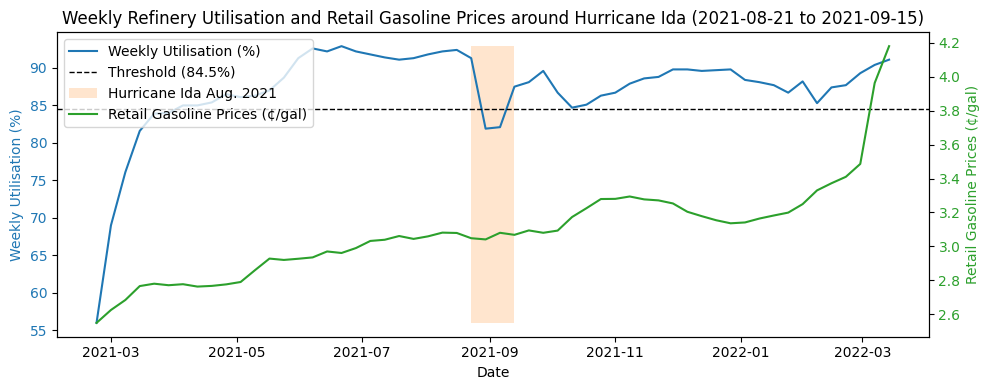

In [66]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd

# Define your event start and end dates
EVENT_START = datetime.datetime(2021, 8, 21)
EVENT_END = datetime.datetime(2021, 9, 15)

# Calculate the date range for plotting (6 months before start, 6 months after end)
six_months_before = EVENT_START - datetime.timedelta(days=6*30) # Approximate 6 months
six_months_after = EVENT_END + datetime.timedelta(days=6*30)   # Approximate 6 months

# Filter the DataFrame to include only data within the calculated date range
df_filtered = df[(df['Date'] >= six_months_before) & (df['Date'] <= six_months_after)].copy()

# Create the figure and primary axes (for Utilisation)
fig, ax1 = plt.subplots(figsize=(10, 4))

# Plot Utilisation on the primary axes
ax1.plot(df_filtered['Date'], df_filtered['Utilisation'], lw=1.5, label='Weekly Utilisation (%)', color='tab:blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Weekly Utilisation (%)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.axhline(c_star, ls='--', color='k', lw=1, label=f'Threshold ({c_star}%)')


# Create a secondary axes (for Retail Gasoline Prices)
ax2 = ax1.twinx()

# Plot Retail Gasoline Prices on the secondary axes
ax2.plot(df_filtered['Date'], df_filtered['Retail Gasoline Prices'], lw=1.5, label='Retail Gasoline Prices (¢/gal)', color='tab:green')
ax2.set_ylabel('Retail Gasoline Prices (¢/gal)', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')


# Highlight the event period within the filtered data for both axes
ax1.fill_between(
    df_filtered['Date'],
    df_filtered['Utilisation'].min(),
    df_filtered['Utilisation'].max(),
    where=(df_filtered['Date'] >= EVENT_START) & (df_filtered['Date'] <= EVENT_END),
    facecolor='tab:orange',
    alpha=0.2,
    label='Hurricane Ida Aug. 2021'
)

# Combine the legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')


plt.title(f'Weekly Refinery Utilisation and Retail Gasoline Prices around Hurricane Ida ({EVENT_START.date()} to {EVENT_END.date()})')
fig.tight_layout()  # Adjust layout to prevent labels overlapping
plt.show()

In [67]:
TEST_START = '2025-01-01'
TEST_END = '2025-05-01'

# 1. Load your CSVs
price = pd.read_csv('weekly_retail_price.csv', parse_dates=['Date'])
util  = pd.read_csv('weekly_utilisation.csv', parse_dates=['Date'])
wti = pd.read_csv('weekly_wti.csv', parse_dates=['Date'])
stocks = pd.read_csv('weekly_ending_gasoline_stock.csv', parse_dates=['Date'])

# 2. Convert each Date into a weekly Period ending on Sunday
#    (this ensures any minor weekday offsets collapse into the same week)
price['Week'] = price['Date'].dt.to_period('W-SUN')  # :contentReference[oaicite:0]{index=0} :contentReference[oaicite:1]{index=1}
util ['Week'] = util ['Date'].dt.to_period('W-SUN')
wti['Week'] = wti['Date'].dt.to_period('W-SUN')
stocks['Week'] = stocks['Date'].dt.to_period('W-SUN')

# 3. Aggregate to one row per week (in case your CSV has multiple entries)
price_w = price .groupby('Week')['Retail Gasoline Prices'].mean().reset_index()
util_w  = util  .groupby('Week')['Utilisation'].mean().reset_index()
wti_w = wti.groupby('Week')['WTI'].mean().reset_index()
stocks_w = stocks.groupby('Week')['Weekly U.S. Ending Stocks of Total Gasoline  (Thousand Barrels)'].mean().reset_index()
stocks_w.rename(columns={'Weekly U.S. Ending Stocks of Total Gasoline  (Thousand Barrels)': 'Gasoline ending stocks'}, inplace=True)

# 4. Merge on the Week period, then restore a plotting Date if needed
df = pd.merge(price_w, util_w, on='Week', how='inner')
df = pd.merge(df, wti_w, on='Week', how='inner')
df = pd.merge(df, stocks_w, on='Week', how='inner')
df['Date'] = df['Week'].dt.to_timestamp('S')  # “S” = period end (Sunday) :contentReference[oaicite:2]{index=2}

# 5. Create your forward‐lead price change
rolling_window = 2
df['dPrice'] = df['Retail Gasoline Prices'].shift(-rolling_window) - df['Retail Gasoline Prices']

# Dropping COVID-period
df_backtest = df[df['Date'].between(TEST_START, TEST_END)]
# df = df[~df["Date"].between("2020-03-01", "2021-12-31")]

# 6. Drop any NaNs and you’re good
df_backtest = df_backtest.dropna(subset=['Utilisation','dPrice']).reset_index(drop=True)

print(df_backtest.head())


                    Week  Retail Gasoline Prices  Utilisation    WTI  \
0  2025-01-06/2025-01-12                   2.958         91.7  75.14   
1  2025-01-13/2025-01-19                   2.950         85.9  79.28   
2  2025-01-20/2025-01-26                   3.011         83.5  75.73   
3  2025-01-27/2025-02-02                   3.006         84.5  73.31   
4  2025-02-03/2025-02-09                   2.972         85.0  72.05   

   Gasoline ending stocks       Date  dPrice  
0                243566.0 2025-01-06   0.053  
1                245898.0 2025-01-13   0.056  
2                248855.0 2025-01-20  -0.039  
3                251088.0 2025-01-27   0.016  
4                248053.0 2025-02-03   0.049  


<ipython-input-67-6f09da5294f8>:28: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['Date'] = df['Week'].dt.to_timestamp('S')  # “S” = period end (Sunday) :contentReference[oaicite:2]{index=2}


2025-01-27 00:00:00 2025-01-27 00:00:00 1
2025-02-10 00:00:00 2025-02-10 00:00:00 -1

Trades: 2, Avg PnL/trade = 0.00¢, Total = 0.04¢


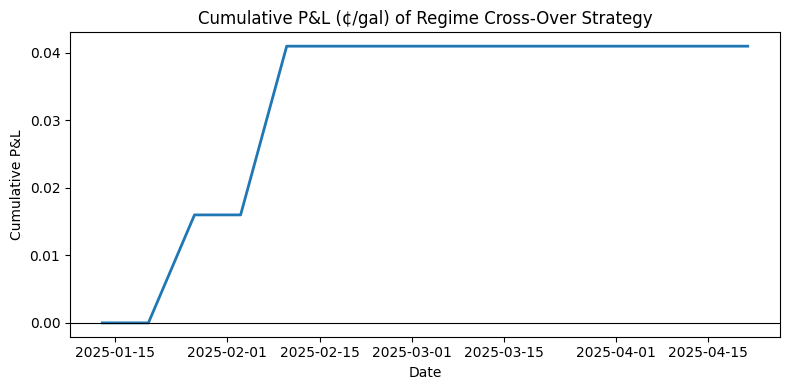

In [68]:
# ── 4. Build cross-over signals ────────────────────────────────────────────────
df_backtest["StressPrev"] = (df_backtest["Utilisation"] > c_star).shift(1)
df_backtest["Stress"]     = (df_backtest["Utilisation"] > c_star)
df_backtest = df_backtest.dropna().reset_index(drop=True)

# Signal = +1 when you *exit* stress into easy (expect price ↑),
#         −1 when you *enter* stress regime (expect price ↓)
df_backtest["Signal"] = 0
df_backtest.loc[(df_backtest["StressPrev"]==True)  & (df_backtest["Stress"]==False), "Signal"] = +1
df_backtest.loc[(df_backtest["StressPrev"]==False) & (df_backtest["Stress"]==True),  "Signal"] = -1

holding_weeks = 1
# Shift so you trade *next* week, then hold exactly N weeks
df_backtest["Position"] = 0
for idx in df_backtest.index:
    sig = df_backtest.at[idx, "Signal"]
    if sig != 0:
        start = idx + 1
        end   = idx + int(holding_weeks)
        df_backtest.loc[start:end, "Position"] = sig
        print(df_backtest.iloc[start]['Date'], df_backtest.iloc[end]['Date'], sig)

# ── 5. Compute P&L ────────────────────────────────────────────────────────────
df_backtest["StratRet"] = df_backtest["Position"] * df_backtest["dPrice"]     # ¢/gal per trade
df_backtest["CumPnL"]   = df_backtest["StratRet"].cumsum()

# Summary
n_trades = int((df_backtest["Signal"] != 0).sum())
avg_pnl  = df_backtest.loc[df_backtest["Signal"] != 0, "StratRet"].mean()
total_pnl= df_backtest["StratRet"].sum()
print(f"\nTrades: {n_trades}, Avg PnL/trade = {avg_pnl:.2f}¢, Total = {total_pnl:.2f}¢")

# ── 6. Plot cumulative P&L ───────────────────────────────────────────────────█
plt.figure(figsize=(8,4))
plt.plot(df_backtest["Date"], df_backtest["CumPnL"], lw=2)
plt.axhline(0, color="k", lw=0.8)
plt.title("Cumulative P&L (¢/gal) of Regime Cross-Over Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative P&L")
plt.tight_layout()
plt.show()

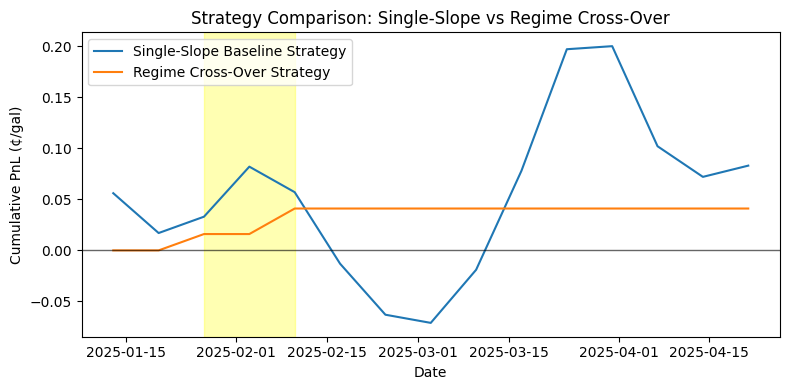

>>> Baseline (single-slope) PnL: 0.08 ¢/gal
>>> Cross-Over   PnL: 0.04 ¢/gal
>>> Δ PnL   : -0.04 ¢/gal


In [70]:
from datetime import datetime

# Define the dates
ENTER_LONG_DATE = '2025-01-27'
ENTER_SHORT_DATE = '2025-02-10'

ENTER_LONG_DATE_dt = datetime.strptime(ENTER_LONG_DATE, '%Y-%m-%d')
ENTER_SHORT_DATE_dt = datetime.strptime(ENTER_SHORT_DATE, '%Y-%m-%d')

# ── 2. Build baseline signals: long if model predicts positive change, else short
df_backtest['pred_dP']     = mod0.predict(X0)
df_backtest['Signal_base'] = np.where(df_backtest['pred_dP'] > 0,  1, -1)

# ── 3. Compute baseline PnL
df_backtest['PnL_base']    = df_backtest['Signal_base'] * df_backtest['dPrice']
df_backtest['CumPnL_base'] = df_backtest['PnL_base'].cumsum()

# ── 4. Bring in your cross-over PnL (assume you have df['CumPnL_xover'])
df_backtest.rename(columns={'CumPnL':'CumPnL_xover'}, inplace=True)

# ── 5. Plot both equity curves for comparison
plt.figure(figsize=(8,4))
plt.plot(df_backtest['Date'], df_backtest['CumPnL_base'], label='Single-Slope Baseline Strategy')
plt.plot(df_backtest['Date'], df_backtest['CumPnL_xover'], label='Regime Cross-Over Strategy')
plt.axhline(0, color='k', lw=1, alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Cumulative PnL (¢/gal)')
plt.title('Strategy Comparison: Single-Slope vs Regime Cross-Over')
plt.legend(loc='upper left')
plt.tight_layout()


# Add the highlight stripe
plt.axvspan(ENTER_LONG_DATE_dt, ENTER_SHORT_DATE_dt, color='yellow', alpha=0.3, label='Highlighted Period')
plt.show()
# ── 6. Print summary stats
print(">>> Baseline (single-slope) PnL:", df_backtest['PnL_base'].sum().round(2), "¢/gal")
print(">>> Cross-Over   PnL:",           df_backtest['StratRet'].sum().round(2),  "¢/gal")
print(">>> Δ PnL   :",                   (df_backtest['StratRet'].sum() - df_backtest['PnL_base'].sum()).round(2), "¢/gal")

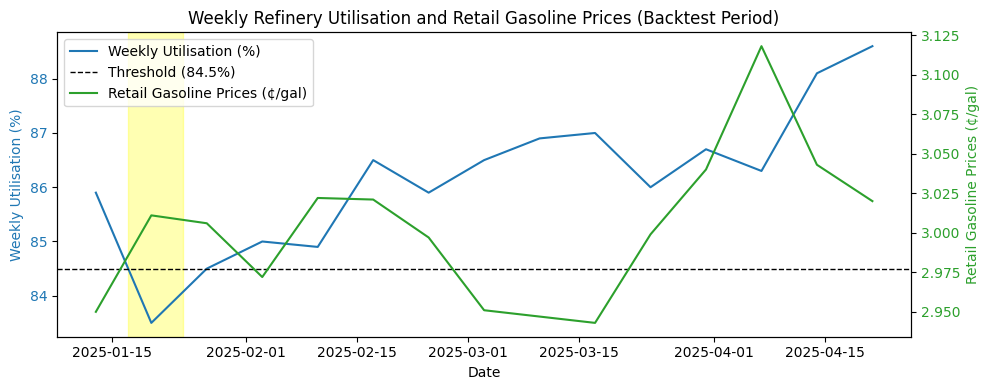

In [71]:
# Create the figure and primary axes (for Utilisation)
fig, ax1 = plt.subplots(figsize=(10, 4))

# Plot Utilisation on the primary axes
ax1.plot(df_backtest['Date'], df_backtest['Utilisation'], lw=1.5, label='Weekly Utilisation (%)', color='tab:blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Weekly Utilisation (%)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.axhline(c_star, ls='--', color='k', lw=1, label=f'Threshold ({c_star}%)')

# Create a secondary axes (for Retail Gasoline Prices)
ax2 = ax1.twinx()

# Plot Retail Gasoline Prices on the secondary axes
ax2.plot(df_backtest['Date'], df_backtest['Retail Gasoline Prices'], lw=1.5, label='Retail Gasoline Prices (¢/gal)', color='tab:green')
ax2.set_ylabel('Retail Gasoline Prices (¢/gal)', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Combine the legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

highlight_start_dt = datetime.strptime('2025-01-17', '%Y-%m-%d')
highlight_end_dt = datetime.strptime('2025-01-24', '%Y-%m-%d')
# Add the highlight stripe
ax1.axvspan(highlight_start_dt, highlight_end_dt, color='yellow', alpha=0.3, label='Highlighted Period')

plt.title('Weekly Refinery Utilisation and Retail Gasoline Prices (Backtest Period)')
fig.tight_layout()
plt.show()